In [1]:
# import libraries

import os
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL
from PIL import Image
from skimage.metrics import structural_similarity as ssim


/hpc/dctrl/ks723/miniconda3/envs/test_pytorch_ipy_v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-03-18 16:15:51,848] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:

'''
Loading test data for model testing

'''

rfactor=256

img_length=rfactor
img_width=rfactor


# for CentOS 8 cluster 
datadir_i='/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Selected_v4_ALL_100AUG'
datadir_o='/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed_100AUG'


path_i=os.path.join(datadir_i)
path_o=os.path.join(datadir_o)

input_data=[]
output_data=[]

# parameters for image

img_shape_i=256  # to make image 256x256 after cropping the image
img_shape_o=256   # to make image 256x256 after cropping the image 

# parameters for cropping output of sim hardcoded
top_crop_i = 30
bottom_crop_i = 30
left_crop_i = 31
right_crop_i = 30

####################

### MODIFIED 070924
# Implemented sorting to sort files in a specific order- image with all rotations first and then the second images and rotations

sorted_filenames_path = '/hpc/group/youlab/ks723/miniconda3/Lingchong/sorted_files_full.txt' 

def load_sorted_filenames(file_path):
    with open(file_path, 'r') as file:
        sorted_filenames = [line.strip() for line in file.readlines()]
    return sorted_filenames

##################

# Define the specific indices you want to load
desired_indices = [30100, 31100, 32100, 33100, 34100, 35100, 36100, 37100, 38100, 39100]



def create_input_data(top_crop, bottom_crop, left_crop, right_crop, indices):
    count = 0
    img_filenames_i = load_sorted_filenames(sorted_filenames_path)

    print(f"Total images available: {len(img_filenames_i)}")

    for idx in indices:
        if idx >= len(img_filenames_i):
            print(f"Index {idx} is out of bounds. Skipping.")
            continue  # Skip indices that are out of range

        img = img_filenames_i[idx]
        img_path = os.path.join(path_i, img)
        img_array_i = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img_array_i is None:
            print(f"Failed to read image at index {idx}: {img_path}. Skipping.")
            continue  # Skip if the image couldn't be read

        # Calculate new dimensions after cropping
        new_height = img_array_i.shape[0] - (top_crop + bottom_crop)
        new_width = img_array_i.shape[1] - (left_crop + right_crop)

        # Perform cropping
        new_array_i = img_array_i[top_crop:top_crop + new_height, left_crop:left_crop + new_width]

        # Resize the image
        new_array_i = cv2.resize(new_array_i, (img_length, img_width))

        # Append to training data
        input_data.append([new_array_i])
        count += 1

        # Optional: Print progress
        print(f"Loaded image {count}: Index {idx}")

    print(f"Total images loaded: {count}")


create_input_data(
    top_crop=top_crop_i,
    bottom_crop=bottom_crop_i,
    left_crop=left_crop_i,
    right_crop=right_crop_i,
    indices=desired_indices
)

top_crop_o=30
bottom_crop_o=30
left_crop_o=31
right_crop_o=30

def create_output_data(top_crop, bottom_crop, left_crop, right_crop, indices):
    count = 0
    img_filenames_o = load_sorted_filenames(sorted_filenames_path)

    print(f"Total images available for testing: {len(img_filenames_o)}")

    for idx in indices:
        if idx >= len(img_filenames_o):
            print(f"Index {idx} is out of bounds. Skipping.")
            continue  # Skip indices that are out of range

        img = img_filenames_o[idx]
        img_path = os.path.join(path_o, img)
        img_array_o = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img_array_o is None:
            print(f"Failed to read image at index {idx}: {img_path}. Skipping.")
            continue  # Skip if the image couldn't be read

        ########################
        ## Image Processing
        blur = cv2.GaussianBlur(img_array_o, (5, 5), 0)
        ret3, th3 = cv2.threshold(blur, 110, 255, cv2.THRESH_BINARY)
        img_array_o = th3
        #########################

        # Calculate new dimensions after cropping
        new_height = img_array_o.shape[0] - (top_crop + bottom_crop)
        new_width = img_array_o.shape[1] - (left_crop + right_crop)

        # Perform cropping
        new_array_o = img_array_o[top_crop:top_crop + new_height, left_crop:left_crop + new_width]

        # Resize the image
        new_array_o = cv2.resize(new_array_o, (img_length, img_width))

        # Append to test data
        output_data.append([new_array_o])
        count += 1

        # Optional: Print progress
        print(f"Loaded test image {count}: Index {idx}")

    print(f"Total test images loaded: {count}")

create_output_data(
    top_crop=top_crop_o,
    bottom_crop=bottom_crop_o,
    left_crop=left_crop_o,
    right_crop=right_crop_o,
    indices=desired_indices
)

X=input_data  
y=output_data

X=(np.array(X).reshape(-1,1,img_shape_i,img_shape_i)) #/255.0  # last one is grayscale first minus one is all x
y=(np.array(y).reshape(-1,1,img_shape_o,img_shape_o)) #/255.0

# normalizing images here to be bw 0 and 1 

X=X/255.0 
y=y/255.0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Convert numpy arrays to torch tensors
X = torch.Tensor(X)
y = torch.Tensor(y)


y3=y.repeat(1, 3, 1, 1)
y4=y.repeat(1, 4, 1, 1)


Total images available: 40900
Loaded image 1: Index 30100
Loaded image 2: Index 31100
Loaded image 3: Index 32100
Loaded image 4: Index 33100
Loaded image 5: Index 34100
Loaded image 6: Index 35100
Loaded image 7: Index 36100
Loaded image 8: Index 37100
Loaded image 9: Index 38100
Loaded image 10: Index 39100
Total images loaded: 10
Total images available for testing: 40900
Loaded test image 1: Index 30100
Loaded test image 2: Index 31100
Loaded test image 3: Index 32100
Loaded test image 4: Index 33100
Loaded test image 5: Index 34100
Loaded test image 6: Index 35100
Loaded test image 7: Index 36100
Loaded test image 8: Index 37100
Loaded test image 9: Index 38100
Loaded test image 10: Index 39100
Total test images loaded: 10


In [3]:

"""
Defining NN model (Here: dilResNet)
"""

# Dilated Basic Block similar to PDEArena
class PDEArenaDilatedBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dilation_rates, activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedBlock, self).__init__()

        # Create dilated convolution layers with specified dilation rates
        self.dilated_layers = nn.ModuleList([
            nn.Conv2d(
                in_planes if i == 0 else out_planes, 
                out_planes, 
                kernel_size=3, 
                padding=rate, 
                dilation=rate, 
                bias=False
            )
            for i, rate in enumerate(dilation_rates)
        ])
        
        # Normalization and Activation layers
        self.norm_layers = nn.ModuleList([nn.BatchNorm2d(out_planes) if norm else nn.Identity() for _ in dilation_rates])
        self.activation = activation(inplace=True)

        # Shortcut (1x1 convolution if input and output planes differ)
        self.shortcut = nn.Sequential()
        if in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_planes) if norm else nn.Identity()
            )

    def forward(self, x):
        out = x
        for layer, norm in zip(self.dilated_layers, self.norm_layers):
            out = self.activation(norm(layer(out)))
        return out + self.shortcut(x)  # Residual connection

# Dilated ResNet with Adjustable Layers and Blocks
class PDEArenaDilatedResNet(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, num_blocks=15, dilation_rates=[1, 2, 4, 8], activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedResNet, self).__init__()
        
        self.in_conv = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)  # Input layer
        
        # Stack of dilated blocks
        self.layers = nn.Sequential(
            *[PDEArenaDilatedBlock(hidden_channels, hidden_channels, dilation_rates, activation=activation, norm=norm) for _ in range(num_blocks)]
        )
        
        self.out_conv = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)  # Output layer

    def forward(self, x):
        x = self.in_conv(x)
        x = self.layers(x)
        return self.out_conv(x)

# Example usage
model = PDEArenaDilatedResNet(
    in_channels=4,               # Input channels (e.g., RGB image)
    out_channels=4,              # Output channels (e.g., RGB image or latent channels)
    hidden_channels=64,          # Number of hidden channels
    num_blocks=15,               # Number of dilated blocks (similar to number of ResNet blocks)
    dilation_rates=[1, 2, 4, 8], # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)


In [4]:
'''
Define pre-trained SD VAE for decoding orginal predicted patterns from the latent predicted patterns
ResNet will predict latent representation of patterns 

The difference here compared to training seed to simulation is that the input also needs to be encoded before
being supplied as input to the network-- this is the memory bottleneck

Compared to the sim1->sim2 mapping, this uses fewer samples to test the performance (10 in sim->exp vs 16 in sim1->sim2) and does not run into
OOM issues

'''

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# first load the VAE

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

vae.to(device)

def encode_img(input_img):
    input_img = input_img.repeat(3, 1, 1)
    
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    if len(input_img.shape)<4:
        input_img = input_img.unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(input_img*2 - 1) # Note scaling  # to make outputs from -1 to 1 
    return 0.18215 * latent.latent_dist.sample()


def decode_img(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)    # to make outputs from 0 to 1 
    image = image.detach()
    return image

# Encode the images
encoded_latents = []

# encode latent of 100000 images

for img in range(0, X.shape[0]) :
    latent = encode_img(X[img,:,:,:].to(device))
    encoded_latents.append(latent)

encoded_latents_squeezed=[t.squeeze(0) for t in encoded_latents]

stacked_tensor = torch.stack(encoded_latents_squeezed, dim=0)

NAME='Pixel_32x32x4to32x32x4_dilRESNET_BnW_30k_SimtoExp_Model_v318_Cluster_GPU_tfData-1742298292' 

model.load_state_dict(torch.load(f'/hpc/group/youlab/ks723/miniconda3/saved_models/trained/{NAME}.pt'))
model.to(device)

model.eval()
with torch.no_grad():
    predicted_latents=model(stacked_tensor)  #y3 is the input seed with 3 channels for the UNET 

predicted_latents_rescaled=predicted_latents

# use the vae decoder to convert the encoded images to final patterns

pred_images=decode_img(predicted_latents_rescaled)



/hpc/dctrl/ks723/miniconda3/envs/test_pytorch_ipy_v2/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
'''
Functions for displaying simulation , predicted exp and actual exp(ground truth)

'''
def tensor_to_pil_v2(tensor):
    tensor = tensor.permute(1,2,0)  # Convert to  (height, width, channels)
    return [Image.fromarray((img.numpy() * 255).astype('uint8')) for img in tensor]

def display_predicted_images(input_seed,final_patterns,pred_images, num_samples):

    plt.figure(figsize=(6*num_samples/3,6))
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    
    for i in range(num_samples):

        image_i=tensor_to_pil_v2(input_seed[i,:,:,:])
        image_o=tensor_to_pil_v2(final_patterns[i,:,:,:])
        image_p= tensor_to_pil_v2(pred_images[i,:,:,:].to("cpu"))
        
        ax = plt.subplot(3, num_samples, i + 1)

        plt.imshow(image_i)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
     

        ax = plt.subplot(3, num_samples, i + 1+num_samples)

        plt.imshow(image_o)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax=plt.subplot(3, num_samples, i + 1+ num_samples+ num_samples)

        plt.imshow(image_p,cmap="gray")
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


    plt.show()
    

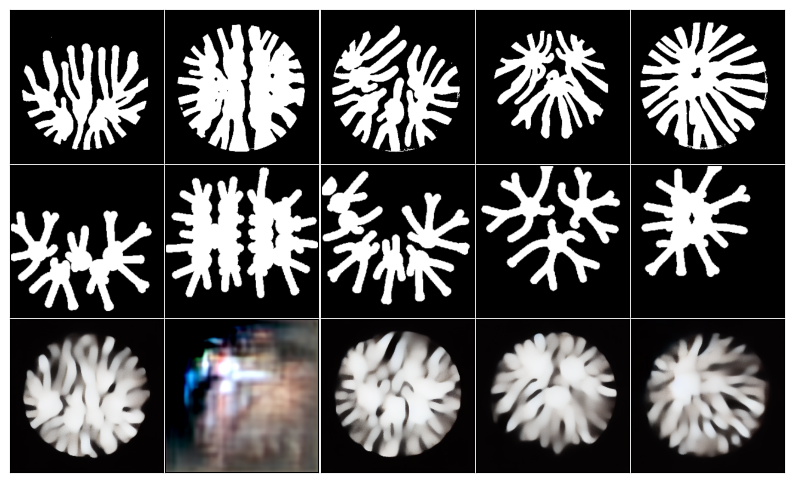

In [6]:
# Display samples from test dataset # this prediction is from the RESNET blocks 
display_predicted_images(y3[4:9,:,:],X[4:9,:,:,:], pred_images[4:9,:,:,:] ,5)  

In [7]:

'''
Functions for computing and displaying SSIM comparisions from predicted and actual images

'''


def tensor_to_pil_v2(tensor):
    tensor = tensor.permute(1, 2, 0)  # Convert to (height, width, channels)
    img = (tensor.cpu().numpy() * 255).astype('uint8')
    return Image.fromarray(img.squeeze())

def compute_ssim_high_precision(original_images, reconstructed_images):
    ssim_values = []
    batch_size = original_images.shape[0]

    for i in range(batch_size):
        # Convert tensors to numpy arrays
        original = original_images[i].cpu().numpy()  # Shape: [channels, height, width]
        reconstructed = reconstructed_images[i].cpu().numpy()

        # Ensure images are in the range [0, 1]
        original = np.clip(original, 0, 1)
        reconstructed = np.clip(reconstructed, 0, 1)

        # Convert to [height, width, channels]
        original = np.transpose(original, (1, 2, 0))  # Shape: [height, width, channels]
        reconstructed = np.transpose(reconstructed, (1, 2, 0))

        # Convert reconstructed RGB image to grayscale using standard luminance formula
        if reconstructed.shape[2] == 3:
            reconstructed_gray = np.dot(reconstructed[..., :3], [0.2989, 0.5870, 0.1140])
        else:
            reconstructed_gray = reconstructed.squeeze(axis=2)

        # Ensure original image is grayscale
        if original.shape[2] == 1:
            original_gray = original.squeeze(axis=2)
        else:
            original_gray = np.dot(original[..., :3], [0.2989, 0.5870, 0.1140])

        # Compute SSIM
        ssim_index = ssim(original_gray, reconstructed_gray, data_range=1.0)
        ssim_values.append(ssim_index)

    return ssim_values




def display_images_with_ssim(reference_images, comparison_images, num_samples=3):
    # Compute SSIM values using high-precision data
    ssim_values = compute_ssim_high_precision(reference_images, comparison_images)

    fig, axes = plt.subplots(4, num_samples, figsize=(num_samples * 4, 16))
    fig.subplots_adjust(hspace=0.3, wspace=0.5)

    for i in range(num_samples):
        # Get the reference and comparison images
        ref_image = reference_images[i].cpu().numpy()  # Shape: [C, H, W] or [H, W]
        comp_image = comparison_images[i].cpu().numpy()  # Shape: [C, H, W]

        print(f"Sample {i}: ref_image.shape = {ref_image.shape}, comp_image.shape = {comp_image.shape}")

        # Handle the reference image (ground truth)
        if ref_image.ndim == 3 and ref_image.shape[0] == 1:
            # Grayscale image, squeeze the channel dimension
            ref_image_disp = ref_image.squeeze(0)  # Shape: [H, W]
        elif ref_image.ndim == 3:
            # If the image has more channels, convert to grayscale
            ref_image_disp = np.transpose(ref_image, (1, 2, 0))
            ref_image_disp = np.dot(ref_image_disp[..., :3], [0.2989, 0.5870, 0.1140])
        elif ref_image.ndim == 2:
            # Already a 2D grayscale image
            ref_image_disp = ref_image  # Shape: [H, W]
        else:
            raise ValueError(f"Unexpected ref_image shape: {ref_image.shape}")

        # Handle the comparison image (predicted image)
        if comp_image.ndim == 3 and comp_image.shape[0] == 3:
            # Transpose to [H, W, C]
            comp_image_disp = np.transpose(comp_image, (1, 2, 0))
            # Convert RGB to grayscale
            comp_image_disp = np.dot(comp_image_disp[..., :3], [0.2989, 0.5870, 0.1140])
        elif comp_image.ndim == 3 and comp_image.shape[0] == 1:
            comp_image_disp = comp_image.squeeze(0)  # Shape: [H, W]
        elif comp_image.ndim == 2:
            comp_image_disp = comp_image  # Shape: [H, W]
        else:
            raise ValueError(f"Unexpected comp_image shape: {comp_image.shape}")

        # Triplicate the single-channel array along the third dimension
        
        image_o=tensor_to_pil_v2(reference_images[i,:,:,:])
        image_p= tensor_to_pil_v2(comparison_images[i,:,:,:].to("cpu"))


        # Triplicate the single-channel array along the third dimension
        image_o_3channel = np.stack([image_o] * 3, axis=-1)
      
        abs_error = np.abs(np.array(image_o_3channel, dtype=np.float32) - np.array(image_p, dtype=np.float32))
        abs_error_image = Image.fromarray(abs_error.astype(np.uint8))
        
        

        # Display the reference image
        axes[0, i].imshow(ref_image_disp, cmap='gray')
        axes[0, i].axis('off')
        # axes[0, i].set_title('Ground Truth')

        # Display the comparison image
        axes[1, i].imshow(comp_image_disp, cmap='gray')
        axes[1, i].axis('off')
        # axes[1, i].set_title('Predicted Image')


        # Display the comparison image
        axes[2, i].imshow(abs_error_image, cmap='gray')
        axes[2, i].axis('off')
        # axes[1, i].set_title('Predicted Image')


        # Display the SSIM score
        axes[3, i].text(0.5, 0.5, f'{ssim_values[i]:.3f}',
                        ha='center', va='center', fontsize=50)
        axes[3, i].axis('off')

    plt.tight_layout()
    plt.show()


Sample 0: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 1: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 2: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 3: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 4: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)


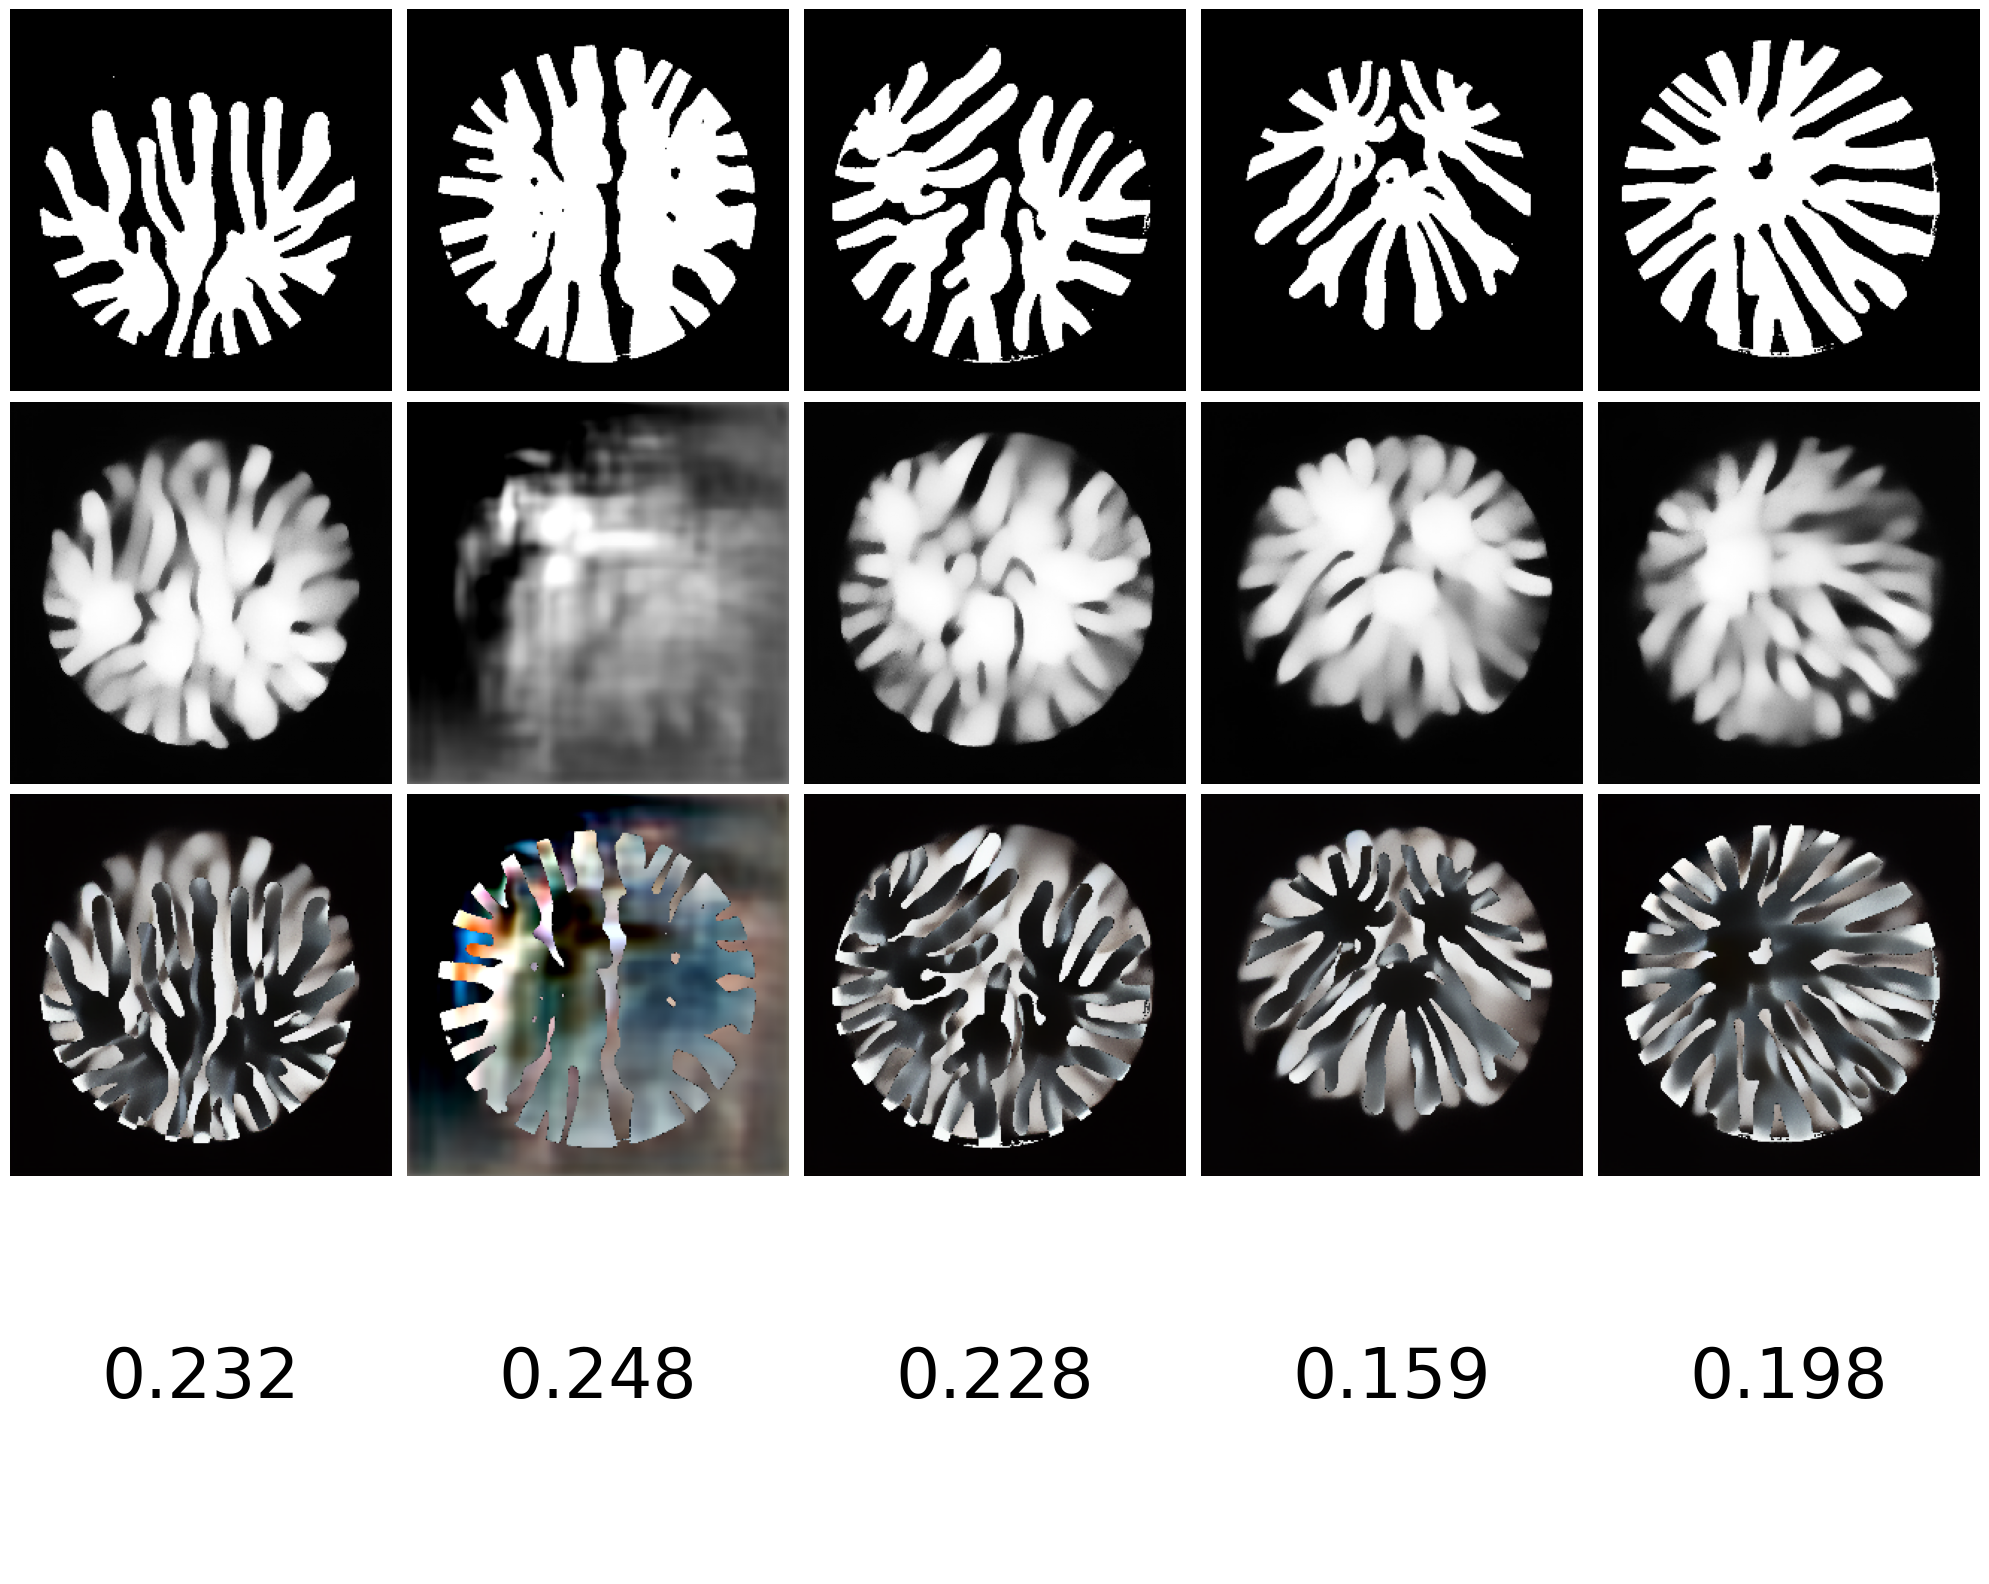

In [8]:
selected_indices = [4,5,6,7,8]

# Assuming X and pred_images are already defined
display_images_with_ssim(y[selected_indices], pred_images[selected_indices], num_samples=5) 

### The following is for seeing the performance on training/validation images for a baseline of how the network is doing. This is done for now by loading images that are in the training set, and applying the final prediction model on that set. Will have to improve this later like seeing the performance in training by using lightning or tensorboard

In [9]:
# import libraries 

import os
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL
import pickle
from PIL import Image


In [10]:
'''
Loading from training data 
'''
    
# for CentOS 8 cluster 
datadir_i='/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Selected_v4_ALL_100AUG'
datadir_o='/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed_100AUG'



path_i=os.path.join(datadir_i)
path_o=os.path.join(datadir_o)

input_data=[]
output_data=[]

# parameters for image

img_shape_i=256  # to make image 256x256 after cropping the image
img_shape_o=256   # to make image 32x32 after cropping the image 


# parameters for cropping output of sim hardcoded
top_crop_i = 30
bottom_crop_i = 30
left_crop_i = 31
right_crop_i = 30

####################

### MODIFIED 070924
# Implemented sorting to sort files in proper order 

sorted_filenames_path = '/hpc/group/youlab/ks723/miniconda3/Lingchong/sorted_files_full.txt' 

def load_sorted_filenames(file_path):
    with open(file_path, 'r') as file:
        sorted_filenames = [line.strip() for line in file.readlines()]
    return sorted_filenames

##################

# Define the specific indices you want to load
desired_indices = [10100, 11100, 12100, 13100, 14100, 15100, 16100, 17100, 18100, 19100]


def create_input_data(top_crop, bottom_crop, left_crop, right_crop, indices):
    count = 0
    img_filenames_i = load_sorted_filenames(sorted_filenames_path)

    print(f"Total images available: {len(img_filenames_i)}")

    for idx in indices:
        if idx >= len(img_filenames_i):
            print(f"Index {idx} is out of bounds. Skipping.")
            continue  # Skip indices that are out of range

        img = img_filenames_i[idx]
        img_path = os.path.join(path_i, img)
        img_array_i = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img_array_i is None:
            print(f"Failed to read image at index {idx}: {img_path}. Skipping.")
            continue  # Skip if the image couldn't be read

        # Calculate new dimensions after cropping
        new_height = img_array_i.shape[0] - (top_crop + bottom_crop)
        new_width = img_array_i.shape[1] - (left_crop + right_crop)

        # Perform cropping
        new_array_i = img_array_i[top_crop:top_crop + new_height, left_crop:left_crop + new_width]

        # Resize the image
        new_array_i = cv2.resize(new_array_i, (img_length, img_width))

        # Append to training data
        input_data.append([new_array_i])
        count += 1

        # Optional: Print progress
        print(f"Loaded image {count}: Index {idx}")

    print(f"Total images loaded: {count}")


create_input_data(
    top_crop=top_crop_i,
    bottom_crop=bottom_crop_i,
    left_crop=left_crop_i,
    right_crop=right_crop_i,
    indices=desired_indices
)

top_crop_o=30
bottom_crop_o=30
left_crop_o=31
right_crop_o=30

def create_output_data(top_crop, bottom_crop, left_crop, right_crop, indices):
    count = 0
    img_filenames_o = load_sorted_filenames(sorted_filenames_path)

    print(f"Total images available for testing: {len(img_filenames_o)}")

    for idx in indices:
        if idx >= len(img_filenames_o):
            print(f"Index {idx} is out of bounds. Skipping.")
            continue  # Skip indices that are out of range

        img = img_filenames_o[idx]
        img_path = os.path.join(path_o, img)
        img_array_o = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img_array_o is None:
            print(f"Failed to read image at index {idx}: {img_path}. Skipping.")
            continue  # Skip if the image couldn't be read

        ########################
        ## Image Processing
        blur = cv2.GaussianBlur(img_array_o, (5, 5), 0)
        ret3, th3 = cv2.threshold(blur, 110, 255, cv2.THRESH_BINARY)
        img_array_o = th3
        #########################

        # Calculate new dimensions after cropping
        new_height = img_array_o.shape[0] - (top_crop + bottom_crop)
        new_width = img_array_o.shape[1] - (left_crop + right_crop)

        # Perform cropping
        new_array_o = img_array_o[top_crop:top_crop + new_height, left_crop:left_crop + new_width]

        # Resize the image
        new_array_o = cv2.resize(new_array_o, (img_length, img_width))

        # Append to test data
        output_data.append([new_array_o])
        count += 1

        # Optional: Print progress
        print(f"Loaded test image {count}: Index {idx}")

    print(f"Total test images loaded: {count}")

create_output_data(
    top_crop=top_crop_o,
    bottom_crop=bottom_crop_o,
    left_crop=left_crop_o,
    right_crop=right_crop_o,
    indices=desired_indices
)


# X is the inputs with the final patterns, y is the one with the images

X=input_data  
y=output_data

X=(np.array(X).reshape(-1,1,img_shape_i,img_shape_i)) #/255.0  # last one is grayscale first minus one is all x
y=(np.array(y).reshape(-1,1,img_shape_o,img_shape_o)) #/255.0

# normalizing images here to be bw 0 and 1 

X=X/255.0 
y=y/255.0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# generate the latents for the data


# Convert numpy arrays to torch tensors
X = torch.Tensor(X)
y = torch.Tensor(y)


y3=y.repeat(1, 3, 1, 1)
y4=y.repeat(1, 4, 1, 1)



Total images available: 40900
Loaded image 1: Index 10100
Loaded image 2: Index 11100
Loaded image 3: Index 12100
Loaded image 4: Index 13100
Loaded image 5: Index 14100
Loaded image 6: Index 15100
Loaded image 7: Index 16100
Loaded image 8: Index 17100
Loaded image 9: Index 18100
Loaded image 10: Index 19100
Total images loaded: 10
Total images available for testing: 40900
Loaded test image 1: Index 10100
Loaded test image 2: Index 11100
Loaded test image 3: Index 12100
Loaded test image 4: Index 13100
Loaded test image 5: Index 14100
Loaded test image 6: Index 15100
Loaded test image 7: Index 16100
Loaded test image 8: Index 17100
Loaded test image 9: Index 18100
Loaded test image 10: Index 19100
Total test images loaded: 10


In [11]:

"""
Defining NN model (Here: dilResNet)
"""

# Dilated Basic Block similar to PDEArena
class PDEArenaDilatedBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dilation_rates, activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedBlock, self).__init__()

        # Create dilated convolution layers with specified dilation rates
        self.dilated_layers = nn.ModuleList([
            nn.Conv2d(
                in_planes if i == 0 else out_planes, 
                out_planes, 
                kernel_size=3, 
                padding=rate, 
                dilation=rate, 
                bias=False
            )
            for i, rate in enumerate(dilation_rates)
        ])
        
        # Normalization and Activation layers
        self.norm_layers = nn.ModuleList([nn.BatchNorm2d(out_planes) if norm else nn.Identity() for _ in dilation_rates])
        self.activation = activation(inplace=True)

        # Shortcut (1x1 convolution if input and output planes differ)
        self.shortcut = nn.Sequential()
        if in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_planes) if norm else nn.Identity()
            )

    def forward(self, x):
        out = x
        for layer, norm in zip(self.dilated_layers, self.norm_layers):
            out = self.activation(norm(layer(out)))
        return out + self.shortcut(x)  # Residual connection

# Dilated ResNet with Adjustable Layers and Blocks
class PDEArenaDilatedResNet(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, num_blocks=15, dilation_rates=[1, 2, 4, 8], activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedResNet, self).__init__()
        
        self.in_conv = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)  # Input layer
        
        # Stack of dilated blocks
        self.layers = nn.Sequential(
            *[PDEArenaDilatedBlock(hidden_channels, hidden_channels, dilation_rates, activation=activation, norm=norm) for _ in range(num_blocks)]
        )
        
        self.out_conv = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)  # Output layer

    def forward(self, x):
        x = self.in_conv(x)
        x = self.layers(x)
        return self.out_conv(x)

# Example usage
model = PDEArenaDilatedResNet(
    in_channels=4,               # Input channels (e.g., RGB image)
    out_channels=4,              # Output channels (e.g., RGB image or latent channels)
    hidden_channels=64,          # Number of hidden channels
    num_blocks=15,               # Number of dilated blocks (similar to number of ResNet blocks)
    dilation_rates=[1, 2, 4, 8], # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)


In [12]:

'''
Since we are dealing with training dataset, the latents for simulation input have already been encoded and saved as pickle files
Here we just load them from the pickle files
'''

def scale_latents(latent):
    # Normalize latent for visualization
    latent = latent - latent.min()
    latent = latent / latent.max()
    return latent



pickle_in=open("/hpc/group/youlab/ks723/miniconda3/Lingchong/Latents/latent_dim_SimcorrtoExp_images_40900_4channels_4x32x32_07092024.pickle","rb")
yprime_in=pickle.load(pickle_in)

yprime_in=yprime_in[desired_indices,:,:,:]

yprime_in = torch.Tensor(yprime_in)


yprime_in_scaled=scale_latents(yprime_in)



In [14]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# first load the VAE

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

vae.to(device)

def encode_img(input_img):
    input_img = input_img.repeat(3, 1, 1)
    
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    if len(input_img.shape)<4:
        input_img = input_img.unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(input_img*2 - 1) # Note scaling  # to make outputs from -1 to 1 
    return 0.18215 * latent.latent_dist.sample()

def decode_img(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)    # to make outputs from 0 to 1 
    image = image.detach()
    return image


# Encode the images
encoded_latents = []


# encode latent of 100000 images

for img in range(0, X.shape[0]) :
    latent = encode_img(X[img,:,:,:].to(device))
    encoded_latents.append(latent)

encoded_latents_squeezed=[t.squeeze(0) for t in encoded_latents]

stacked_tensor = torch.stack(encoded_latents_squeezed, dim=0)

NAME='Pixel_32x32x4to32x32x4_dilRESNET_BnW_30k_SimtoExp_Model_v318_Cluster_GPU_tfData-1742298292'  

model.load_state_dict(torch.load(f'/hpc/group/youlab/ks723/miniconda3/saved_models/trained/{NAME}.pt'))
model.to(device)

model.eval()
with torch.no_grad():
    predicted_latents=model(stacked_tensor)  #y3 is the input seed with 3 channels for the UNET 



predicted_latents_rescaled=scale_latents(predicted_latents)



# use the vae decoder to convert the encoded images to final patterns

pred_images=decode_img(predicted_latents)


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


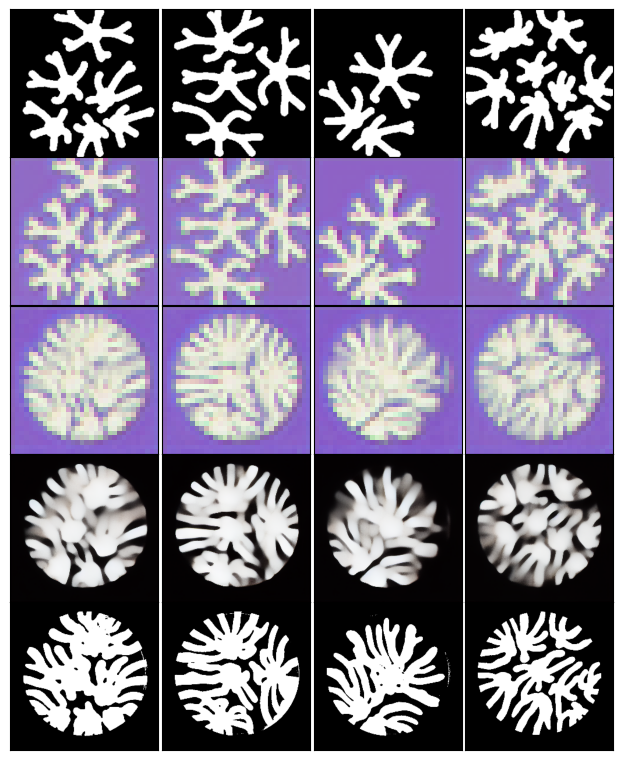

In [15]:

'''
Functions for displaying sim, latent simulation 1, predicted latent exp 2, predicted exp  and actual exp



'''
def tensor_to_pil_v2(tensor):
    tensor = tensor.permute(1,2,0)  # Convert to  (height, width, channels)
    return [Image.fromarray((img.numpy() * 255).astype('uint8')) for img in tensor]

def display_predicted_images(input_seed,actual_latents,pred_latents,pred_images,final_patterns, num_samples):
   

    fig, ax = plt.subplots(5,num_samples, figsize=(6.8, 8))  
    fig.tight_layout()

  
    plt.subplots_adjust(wspace=0.001, hspace=0.001)

   

    for i in range(num_samples):

        image_i=tensor_to_pil_v2(input_seed[i,:,:,:])
        image_o=tensor_to_pil_v2(final_patterns[i,:,:,:])
        image_p= tensor_to_pil_v2(pred_images[i,:,:,:].to("cpu"))

        image_al=tensor_to_pil_v2(actual_latents[i,:,:,:].to("cpu"))
        image_pl=tensor_to_pil_v2(pred_latents[i,:,:,:].to("cpu"))
     

        ax[0,i].imshow(image_i,cmap='gray')
        ax[0,i].get_xaxis().set_visible(False)
        ax[0,i].get_yaxis().set_visible(False)
      

        ax[1,i].imshow(image_al,cmap='gray')
        ax[1,i].get_xaxis().set_visible(False)
        ax[1,i].get_yaxis().set_visible(False)
       

        ax[2,i].imshow(image_pl,cmap="gray")
        ax[2,i].get_xaxis().set_visible(False)
        ax[2,i].get_yaxis().set_visible(False)
   

        ax[3,i].imshow(image_p,cmap="gray")
        ax[3,i].get_xaxis().set_visible(False)
        ax[3,i].get_yaxis().set_visible(False)
       

        
        ax[4,i].imshow(image_o,cmap="gray")
        ax[4,i].get_xaxis().set_visible(False)
        ax[4,i].get_yaxis().set_visible(False)

        print(np.array(image_p).shape)
    
    

    plt.show()

# Display samples from train dataset


display_predicted_images(X[0:9,:,:,:],yprime_in_scaled[0:9,:,:,:],predicted_latents_rescaled[0:9,:,:,:],pred_images[0:9,:,:,:],y[0:9,:,:,:] ,4) # 
